<a href="https://colab.research.google.com/github/maiaufrrj/superstore_data/blob/main/modelo_LSTM_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [83]:
#!pip install scikit-learn==0.24

In [84]:
from pandas import DataFrame, Series, concat, read_csv, datetime
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.metrics import MeanAbsolutePercentageError
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from math import sqrt
from matplotlib import pyplot
import numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [85]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
  early_stop=EarlyStopping(monitor='loss', patience = 30)
  X, y = train[:, 0:-1], train[:, -1]
  X = X.reshape(X.shape[0], 1, X.shape[1])
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mape', optimizer='adam')
  for i in range(nb_epoch):
    model.fit(X, y, epochs=100, batch_size=batch_size, verbose=0, shuffle=False, callbacks=[early_stop])
    model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]



In [86]:
# load dataset
series = read_csv('https://raw.githubusercontent.com/maiaufrrj/superstore_data/main/df_final.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
 
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [87]:
#df_final carregado do github
series

ds
2011-01-31    138241.30042
2011-02-28    134969.94086
2011-03-31    171455.59372
2011-04-30    128833.47034
2011-05-31    148146.72092
2011-06-30    189338.43966
2011-07-31    162034.69756
2011-08-31    219223.49524
2011-09-30    255237.89698
2011-10-31    204675.07846
2011-11-30    214934.29386
2011-12-31    292359.96752
2012-01-31    162800.89338
2012-02-29    152661.15144
2012-03-31    201608.72784
2012-04-30    187469.96192
2012-05-31    218960.16042
2012-06-30    249289.77172
2012-07-31    174394.02808
2012-08-31    271669.66086
2012-09-30    256567.85308
2012-10-31    239321.09904
2012-11-30    270723.05356
2012-12-31    291972.33306
2013-01-31    206459.19582
2013-02-28    191062.77216
2013-03-31    230547.79468
2013-04-30    233181.34844
2013-05-31    304509.96336
2013-06-30    341162.34370
2013-07-31    223642.65664
2013-08-31    323876.60716
2013-09-30    326897.27044
2013-10-31    270121.87570
2013-11-30    383039.21248
2013-12-31    371245.40880
2014-01-31    268265.5224

In [88]:
 # fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
 
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 

Month=1, Predicted=361577.435479, Expected=268265.522400
Month=2, Predicted=259669.090702, Expected=244159.304860
Month=3, Predicted=234582.808113, Expected=347720.968680
Month=4, Predicted=336468.414683, Expected=302132.540000
Month=5, Predicted=291705.336826, Expected=304798.836040
Month=6, Predicted=294241.385402, Expected=372577.232980
Month=7, Predicted=361574.151905, Expected=278672.173260
Month=8, Predicted=268870.694516, Expected=432731.041940
Month=9, Predicted=421746.719819, Expected=405436.705840
Month=10, Predicted=395813.570955, Expected=406659.415000
Month=11, Predicted=397294.556325, Expected=508954.731560
Month=12, Predicted=499106.822661, Expected=427757.398000


Test RMSE: 82107.725


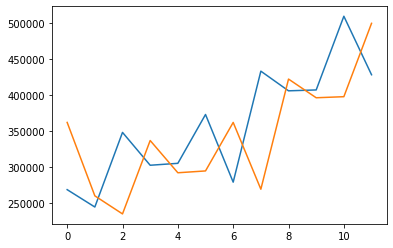

In [89]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))

print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

In [90]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape=mean_absolute_percentage_error(raw_values[-12:], predictions)
mape = "%0.2f" % mape
print('Ao longo da série temos uma MAPE de: ' + mape + '%')

Ao longo da série temos uma MAPE de: 18.61%
